# Machine Learning technique on PET block detector development - Part 2

## Crystal/Pixel discrimination for DQS PET block detector using Machine Learning techniques (v1.0, 2019-09)
---


- This report describes the algorithm(s) to discrimanate the scintillation crystals (pixels) being fired by gammas in the block detectors
- The block under investigation is built using the Dichotomous Orthogonal Symmetry ([DOS](https://iopscience.iop.org/article/10.1088/0031-9155/61/4/1608)) design (https://iopscience.iop.org/article/10.1088/0031-9155/61/4/1608)
- The raw data is generated by Monte Carlo simulations using [GATE](http://www.opengatecollaboration.org/) (http://www.opengatecollaboration.org/)
- In order to read root file, the **uproot** package is needed ([link1](https://pypi.org/project/uproot/), [link2](https://github.com/scikit-hep/uproot)).
---

In [237]:
# load libraries

import uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
# %matplotlib qt
%matplotlib inline
# %matplotlib notebook

import pickle
from sklearn.externals import joblib
import time

plt.rcParams['figure.dpi'] = 120 # default is 72

### 1. Raw data structure
***
- There are two TTree in the Monte Carlo simulation generated root file: **OpticalSinglesOpticaladder** and **SinglesAdder**.  
  Each tree consists of a series of records which has 26 fields:
  'runID',
  'eventID',
  'sourceID',
  'sourcePosX',
  'sourcePosY',
  'sourcePosZ',
  'time',  
  'energy',
  'globalPosX',
  'globalPosY',
  'globalPosZ',
  'gantryID',
  'rsectorID',
  'moduleID',
  'submoduleID',
  'crystalID',
  'layerID',  
  'comptonPhantom',
  'comptonCrystal',
  'RayleighPhantom',
  'RayleighCrystal',
  'axialPos',
  'rotationAngle',
  'comptVolName',  
  'RayleighVolName',
  'septalNb'.  
    
- The energy in the OpticalSinglesOpticaladder tree is the number of photons received by each photo sensors (SiPMs),  
while the energy in the SinglesAdder tree is the deposited energy (in MeV) at each interaction location inside the  
scintillation crystal pixels.  
  
- The records with the same runID and eventID in both the SinglesAdder and the OpticalSinglesOpticaladder trees are  
from the same gammas. Since each gamma may interact with the scintillator several times, and the photo sensors that  
received scintillation photons are different for each gamma, therefore, the number of records for the same gamma in the  
SinglesAdder and the OpticalSinglesOpticaladder are usually different. Therefore, sorting algorithms are needed to   
convert the raw data into a organized format for further investigation.  
---

In [4]:
# load raw data from root files
file = "D:\\ML on PET block\\new_concept_block_lso\\new_concept_block_15x15\\results\\new_concept_block4a_planar_source001.root"
fp = uproot.open(file)


In [5]:
fp.allkeys()

[b'latest_event_ID;1',
 b'total_nb_primaries;1',
 b'OpticalSinglesOpticaladder;1',
 b'SinglesAdder;1']

In [6]:
fp.allvalues()

[<b'TH1D' b'latest_event_ID' 0x022614486b88>,
 <b'TH1D' b'total_nb_primaries' 0x022614486f48>,
 <TTree b'OpticalSinglesOpticaladder' at 0x02261448be48>,
 <TTree b'SinglesAdder' at 0x022614e855f8>]

In [7]:
fp.allitems()

[(b'latest_event_ID;1', <b'TH1D' b'latest_event_ID' 0x0226152b1c78>),
 (b'total_nb_primaries;1', <b'TH1D' b'total_nb_primaries' 0x0226152b1f98>),
 (b'OpticalSinglesOpticaladder;1',
  <TTree b'OpticalSinglesOpticaladder' at 0x0226152db2b0>),
 (b'SinglesAdder;1', <TTree b'SinglesAdder' at 0x022616ae6a58>)]

In [8]:
# optical singles adder consists of the photon counts received by each photo sensor
# sigles adder consists of the photon counts deposited at each interaction within the scintillator

opticalsinglesadder = fp["OpticalSinglesOpticaladder"]
singlesadder = fp["SinglesAdder"]


In [9]:
singlesadder.show()

runID                      (no streamer)              asdtype('>i4')
eventID                    (no streamer)              asdtype('>i4')
sourceID                   (no streamer)              asdtype('>i4')
sourcePosX                 (no streamer)              asdtype('>f4')
sourcePosY                 (no streamer)              asdtype('>f4')
sourcePosZ                 (no streamer)              asdtype('>f4')
time                       (no streamer)              asdtype('>f8')
energy                     (no streamer)              asdtype('>f4')
globalPosX                 (no streamer)              asdtype('>f4')
globalPosY                 (no streamer)              asdtype('>f4')
globalPosZ                 (no streamer)              asdtype('>f4')
gantryID                   (no streamer)              asdtype('>i4')
rsectorID                  (no streamer)              asdtype('>i4')
moduleID                   (no streamer)              asdtype('>i4')
submoduleID                (no str

In [10]:
opticalsinglesadder.show()

runID                      (no streamer)              asdtype('>i4')
eventID                    (no streamer)              asdtype('>i4')
sourceID                   (no streamer)              asdtype('>i4')
sourcePosX                 (no streamer)              asdtype('>f4')
sourcePosY                 (no streamer)              asdtype('>f4')
sourcePosZ                 (no streamer)              asdtype('>f4')
time                       (no streamer)              asdtype('>f8')
energy                     (no streamer)              asdtype('>f4')
globalPosX                 (no streamer)              asdtype('>f4')
globalPosY                 (no streamer)              asdtype('>f4')
globalPosZ                 (no streamer)              asdtype('>f4')
gantryID                   (no streamer)              asdtype('>i4')
rsectorID                  (no streamer)              asdtype('>i4')
moduleID                   (no streamer)              asdtype('>i4')
submoduleID                (no str

In [11]:
opticalsinglesadder.name, opticalsinglesadder.title, opticalsinglesadder.numbranches, opticalsinglesadder.numentries

(b'OpticalSinglesOpticaladder', b'The root tree for singles', 26, 8064316)

In [12]:
singlesadder.name, singlesadder.title, singlesadder.numbranches, singlesadder.numentries

(b'SinglesAdder', b'The root tree for singles', 26, 446353)

###  
### 2. Sorting the raw data
***
- A C-like code for Root is developed sorting and filtering the raw events and converting them into a more straight forward  
data structure. The converted data is stored using CSV format as ASCII file.

- The number of fields in the CSV is determined by the structure of the simulated block detector. For the 15 $\times$ 15 LSO  
block in this study, the number of fields is $N_s\times4+4$, where $N_s=9$ is the number of photo sensors along one side of the block.


- The first 3 fields are the "index_x","index_y","index_z", which is the pixel index in X, Y and Z direction. The pixel index in X and Y  
direction are the real pixel/crystal index, however, the pixle/crystal along Z direction is one complete unit in this simualtion.  
Thus the Z index is the discreted index based on delta_z parameter during the sorting.  
  
- The fourth field is the total deposited energy by the gamma in MeV unit.  

- The rest of the fields are the number of photons received by each photo sensors. The first $N_s\times2$ fields are for the sensors on  
the top: "$st0$" to "$st[N_s\times2-1]$", the second $N_s\times2$ fields are the for the sensors on the bottom: "$sb0$" to "$sb[N_s\times2-1]$". 
  
---

In [127]:
file = "D:\\ML on PET block\\new_concept_block_lso\\new_concept_block_15x15\\results\\ML_data\\new_concept_block_15x15_sorted_events1.csv"

df0 = pd.read_csv (file, comment='#')

In [128]:
df0.head()


,index_x,index_y,index_z,energy,st0,st1,st2,st3,st4,st5,...,sb8,sb9,sb10,sb11,sb12,sb13,sb14,sb15,sb16,sb17
0,8,3,5,0.511000,10,1,38,1,45,2,...,6,91,4,16,5,12,1,10,1,4
1,9,9,2,0.481130,5,1,5,4,6,2,...,19,4,93,0,33,2,10,0,7,0
2,5,2,6,0.511000,6,0,24,0,4,2,...,2,44,4,175,1,62,0,27,0,6
3,7,6,8,0.511000,3,2,1,2,7,2,...,6,34,5,7,0,8,1,5,1,2
4,2,3,9,0.332283,0,4,1,7,9,3,...,1,3,1,6,0,24,0,46,0,30


In [129]:
X = df0.iloc[:,4:].values

In [130]:
decoding = df0.iloc[:,0:4].values

In [131]:
# total energy per event in term of photon count
E_photon = np.sum(X, axis=1)


###  
### 3. Energy Spectrum

---

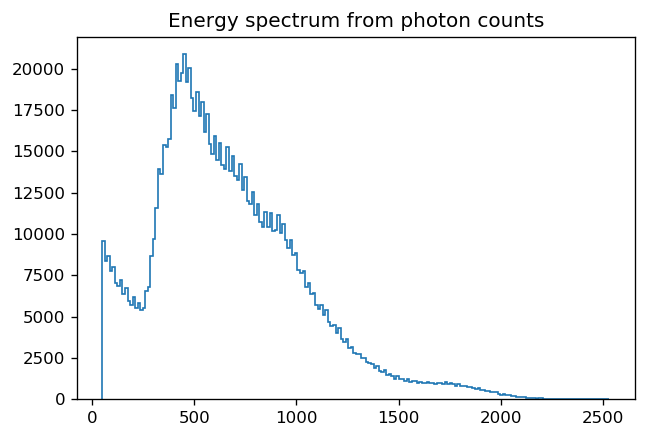

In [246]:
# check the energy spectrum in term of the tatal photon count from all events
fig, ax = plt.subplots()
#ax.set_xlim(min(E_photon), max(E_photon))
#plt.hist(E_photon, bins=200, range=(min(E_photon),max(E_photon)), histtype = 'step')
plt.hist(E_photon, bins=200, histtype = 'step')
ax.set_title("Energy spectrum from photon counts")
plt.savefig(".\\figs2\\Energy_spectrum_from_photon_counts.png", dpi=300)

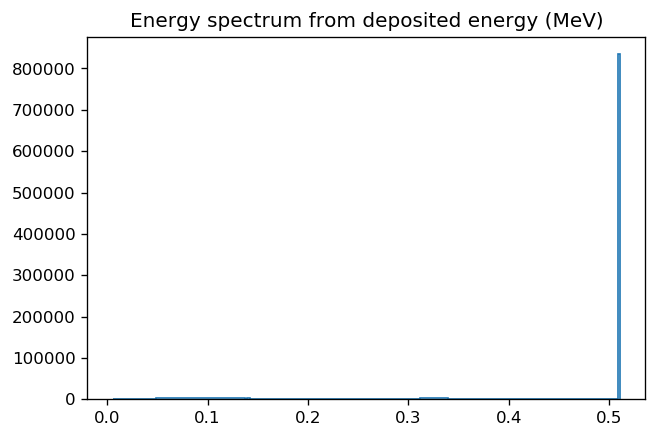

In [247]:
# check the energy spectrum in term of the tatal deposited energy (MeV)
fig, ax = plt.subplots()
# ax.set_xlim(min(E_photon), max(E_photon))
plt.hist(decoding[:,3], bins=200, histtype = 'step')
ax.set_title("Energy spectrum from deposited energy (MeV)")
plt.savefig(".\\figs2\\Energy_spectrum_from_deposited_energy.png", dpi=300)

###  
### 4. Decoding methods and the associated 2D maps  
 \* For the details of the docoding algorithms please refer to the publication [A novel depth-of-interaction block detector for positron emission tomography using a dichotomous orthogonal sysmetry decoding concept](https://iopscience.iop.org/article/10.1088/0031-9155/61/4/1608).

***

#### 4.1 Anger-position decoding

In [134]:
E_top = X[:,0:18]
E_bottom = X[:,18:36]

E_x1 = E_top[:, 0:18:2]
E_x2 = E_top[:, 18:0:-2]

E_y1 = E_bottom[:, 0:18:2]
E_y2 = E_bottom[:, 18:0:-2]

In [135]:
E_left = np.sum(E_x1, axis = 1)
E_right = np.sum(E_x2, axis = 1)

E_front = np.sum(E_y1, axis = 1)
E_back = np.sum(E_y2, axis = 1)

In [136]:
E_h = E_left + E_right
E_h[E_h==0] = 1

E_v = E_front + E_back
E_v[E_v==0] = 1

In [160]:
x_t = np.array(E_left / E_h)
y_t = np.array(E_front / E_v)

#x_t[np.isnan(x_t)] = 0
#y_t[np.isnan(y_t)] = 0

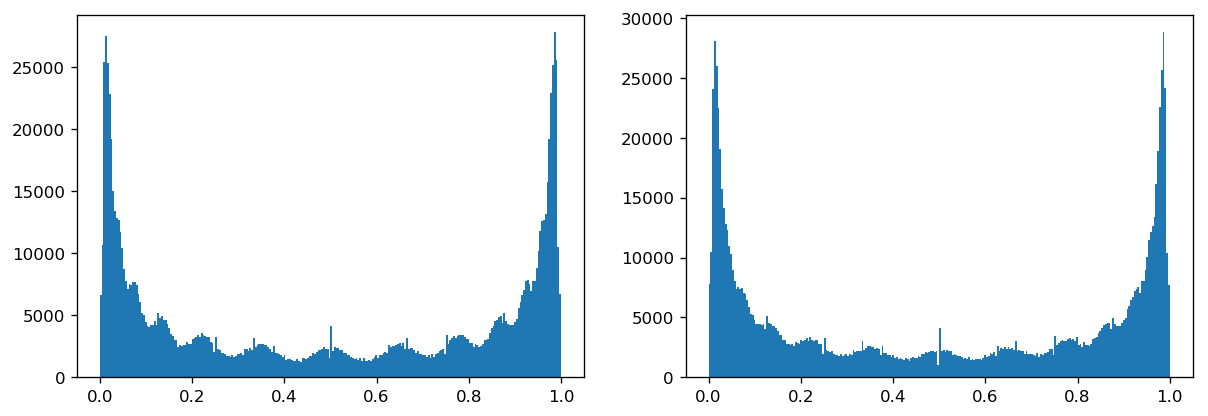

In [248]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(12,4))

#ax.set_title('2d map from anger decoding')
ax[0].hist(x_t, bins=256)
ax[1].hist(y_t, bins=256)

plt.show()

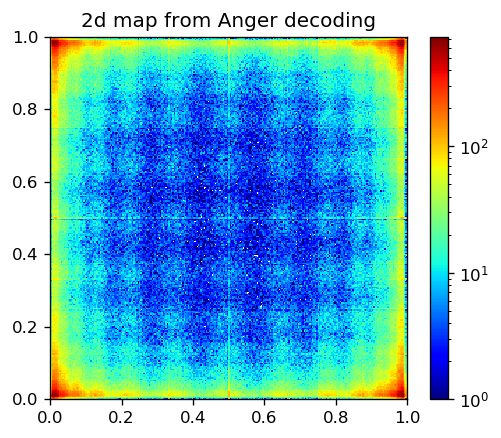

<Figure size 720x480 with 0 Axes>

In [249]:
fig, ax = plt.subplots(figsize=(4.8,4))

ax.set_title('2d map from Anger decoding')
#im = ax.hist2d(x_t, y_t, bins=256, cmap=mpl.cm.jet, cmin=0, cmax=2000)
im = ax.hist2d(x_t, y_t, bins=256, norm = mpl.colors.LogNorm(), cmap=mpl.cm.jet)
fig.colorbar(im[3], ax=ax)
plt.show()
plt.savefig(".\\figs2\\2d_map_anger_decoding.png", dpi=300)

#### 4.2 Light-channel decoding

In [163]:
t0 = E_y1[:,0] + E_y2[:,0]

for j in range(1,9):
    t0 += (E_y1[:,j] + E_y2[:,j]) * (j+1)

x_b = np.array((t0 / (E_front+E_back) - 1) / 8)
x_b[np.isnan(x_b)] = 0

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


In [164]:
t0 = E_x1[:,0] + E_x2[:,0]

for j in range(1,9):
    t0 += (E_x1[:,j] + E_x2[:,j]) * (j+1)

y_b = np.array((t0 / (E_left+E_right) - 1) / 8)
y_b[np.isnan(y_b)] = 0

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


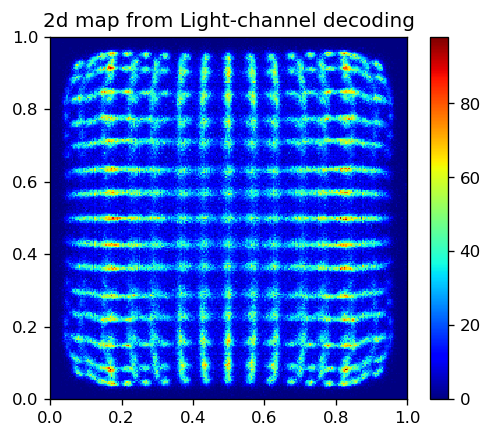

<Figure size 720x480 with 0 Axes>

In [250]:
fig, ax = plt.subplots(figsize=(4.8,4))

ax.set_title('2d map from Light-channel decoding')

im = ax.hist2d(x_b, y_b, bins=256, cmap=mpl.cm.jet, cmin=0, cmax=100)
fig.colorbar(im[3], ax=ax)

plt.show()
plt.savefig(".\\figs2\\2d_map_light_channel_decoding.png", dpi=300)

#### 4.3 Composite decoding

##### 4.3.1 arithmetic mean

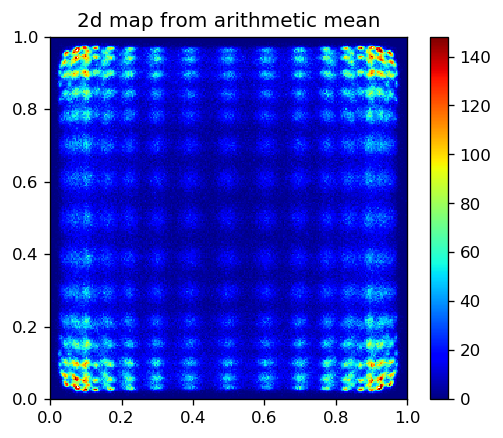

In [251]:
# x, y scale normalized to 1024
x_a =  (x_t + x_b) / 2 
y_a =  (y_t + y_b) / 2

fig, ax = plt.subplots(figsize=(4.8,4))
ax.set_title('2d map from arithmetic mean')
im = ax.hist2d(x_a, y_a, bins=256, cmap=mpl.cm.jet, cmin=0, cmax=150)
fig.colorbar(im[3], ax=ax)
plt.savefig(".\\figs2\\2d_map_arithmetic_mean.png", dpi=300)
plt.show()


##### 4.3.2 geometric mean

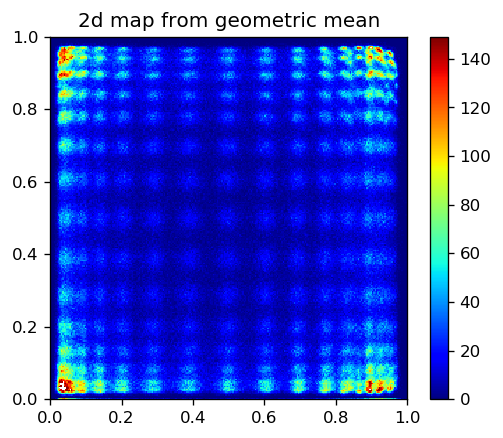

In [252]:
x_g = np.sqrt(x_t * x_b)
y_g = np.sqrt(y_t * y_b) 

fig, ax = plt.subplots(figsize=(4.8,4))
ax.set_title('2d map from geometric mean')
im = ax.hist2d(x_g, y_g, bins=256, cmap=mpl.cm.jet, cmin=0, cmax=150)
fig.colorbar(im[3], ax=ax)
plt.savefig(".\\figs2\\2d_map_geometric_mean.png", dpi=300)
plt.show()


##### 4.3.3 Complex weight function

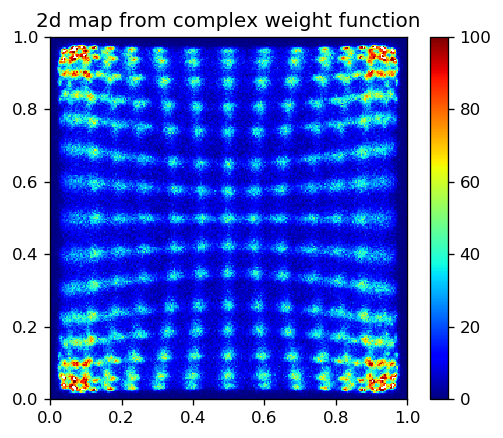

In [240]:
w = 1 - 0.7 * np.sqrt( (x_b-0.5)**2 + (y_b-0.5)**2 ) / 0.707
x_c = x_b * w + x_t * (1-w)
y_c = y_b * w + y_t * (1-w)

fig, ax = plt.subplots(figsize=(4.8,4))
ax.set_title('2d map from complex weight function')
im = ax.hist2d(x_c, y_c, bins=256, cmap=mpl.cm.jet, cmin=0, cmax=100)
fig.colorbar(im[3], ax=ax)
plt.savefig(".\\figs2\\2d_map_comp_weight.png", dpi=300)
plt.show()


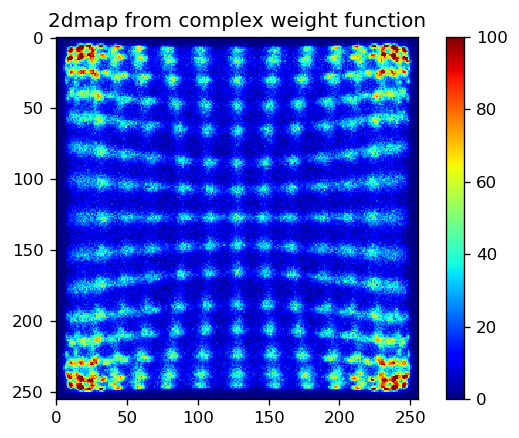

In [253]:
#histgram2d, xedges, yedges = np.histogram2d(x_c, y_c, bins=256, range=[[0,256],[0,256]])
histgram2d, xedges, yedges = np.histogram2d(y_c, x_c, bins=256, range=[[0,1],[0,1]])
im = plt.imshow(histgram2d, cmap='jet', vmax=100, vmin=0)
fig = plt.gcf()
ax = plt.gca()
fig.colorbar(im, ax=ax)
plt.title('2dmap from complex weight function')
plt.savefig(".//figs2//2d_map_comp_wight_1.png", dpi=300)

####  
#### 4.4  Scintillator/pixel discrimination using lookup table 
***


##### 4.4.1 Load the lookup table previously generated by conventional method based on the complex weight function

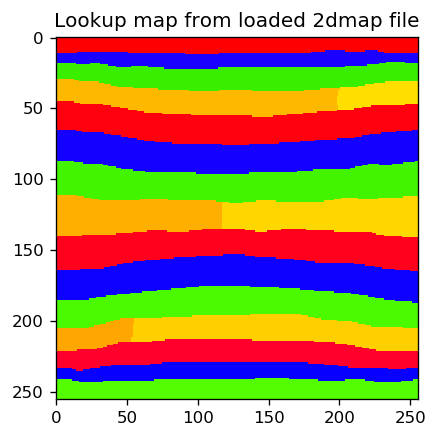

In [242]:
# read the 2D map
# twoD_map_datatype 
# big endian using '>'
twoD_map_datatype = np.dtype('>u4')

file = "D:\\ML on PET block\\new_concept_block_lso\\new_concept_block_15x15\\results\\new_concept_block4a_planar_source_comp1_bigendian_lut2.dat"
lut = np.fromfile(file, dtype=twoD_map_datatype).reshape((256,256))

fig1 = plt.imshow(lut, cmap='prism')
plt.title('Lookup map from loaded 2dmap file')
plt.savefig(".\\figs2\\lut_from_lut_file.png", dpi=300)


#####  
##### 4.4.2 Generate grid from the lookup table

In [233]:
# check the description in Part 1.

def generate_grid(lut):
    """
    generate the grid of the lookup table from the lookup table data
    
    input: lookup table, numpy array
    output: grid as numpy array, the same size as the input 
    """
    
    lut_grid = np.zeros(lut.shape)
    pix_x, pix_y = lut_grid.shape

    for i in range(pix_x-1):
        for j in range(pix_y-1):
            if lut[i,j] != lut[i+1,j]:
                lut_grid[i,j] = 1
                lut_grid[i+1,j] = 1
            if lut[i,j] != lut[i,j+1]:
                lut_grid[i,j] = 1
                lut_grid[i,j+1] = 1
    
    return lut_grid

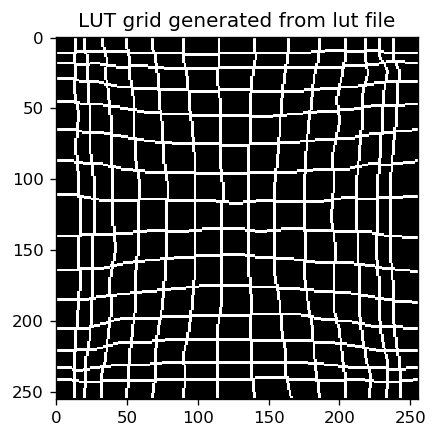

In [243]:
lut_grid = generate_grid(lut)

plt.imshow(lut_grid, cmap="gray")
plt.title("LUT grid generated from lut file")
plt.savefig(".\\figs2\\lut_grid_generated_from_lut_file.png", dpi=300)

#####  
##### 4.4.3 Overlap the lut grid with the 2dmap (histogram)

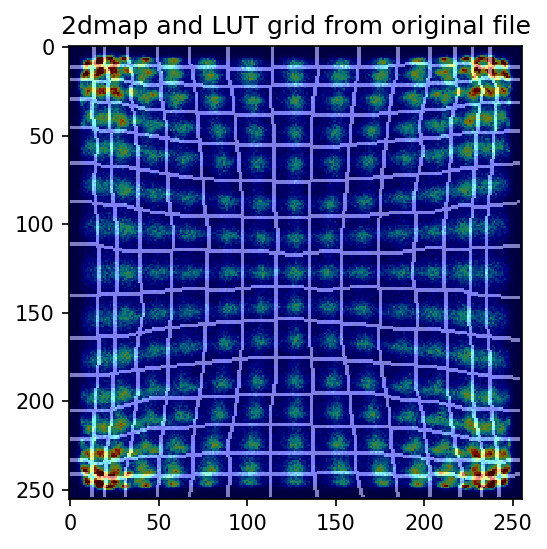

In [245]:
#fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(12,4))
plt.rcParams['figure.dpi'] = 150

#plt.imshow(np.flip(histgram2d, axis=1), vmax = 100, cmap='jet')
plt.imshow(histgram2d, vmax = 100, cmap='jet')
plt.imshow(lut_grid, cmap="gray", alpha=0.5)
plt.title("2dmap and LUT grid from original file")
plt.savefig(".\\figs2\\2dmap_and_lut_grid_from_original_file.png", dpi=300)

plt.rcParams['figure.dpi'] = 120

####  
#### 4.4.4 Scintillator/pixel discrimination using lookup table


###  
### 5. Decoding test  

&nbsp;&nbsp;&nbsp;&nbsp;Since we already defined
```
X = df0.iloc[:,4:].values  
decoding = df0.iloc[:,0:4].values  
```
therefore, the input variables X are the 36 photon sensors and the y variables are the coordinate 
index in X, Y and Z direction.  

First, let's consider the decoding in 2D (XY) plane only. We can generate a unique scintillator/pixel index as  
``` pixel_xy = index_y * 15 + index_x ```  
and train the ML algorithms using XS as the y variable. Or, we can train the ML algorithms use both index_x and index_y repectively.  

***

<function matplotlib.pyplot.show(*args, **kw)>

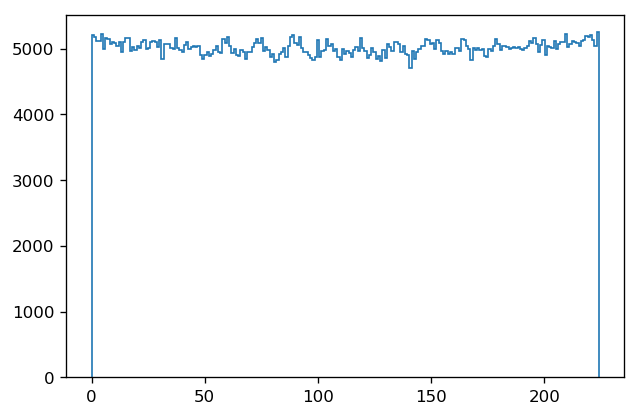

In [270]:
pixel_xy = df0['index_y'] * 15 + df0['index_x']
plt.hist(pixel_xy, bins=225, histtype = 'step')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

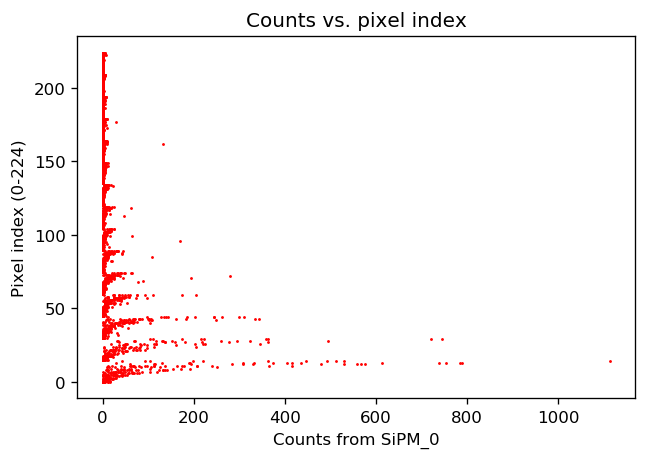

In [318]:
N=3000
plt.scatter(X[:N,0], pixel_xy[0:N], color = 'red', s=0.5)
plt.title('Counts vs. pixel index')
plt.xlabel('Counts from SiPM_0')
plt.ylabel('Pixel index (0-224)')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

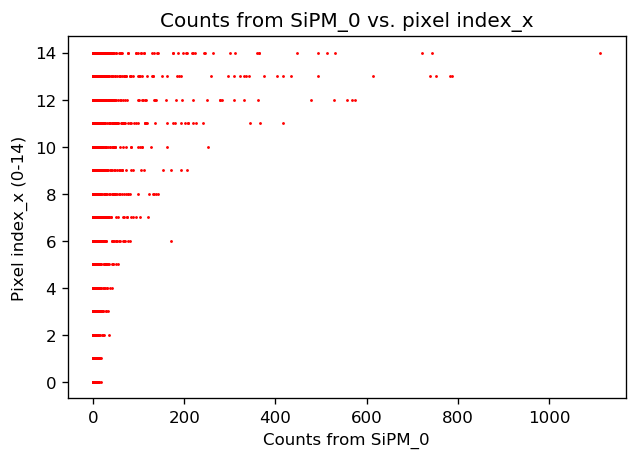

In [319]:
N=3000
plt.scatter(X[:N,0], df0['index_x'][0:N], color = 'red', s=0.5)
plt.title('Counts from SiPM_0 vs. pixel index_x')
plt.xlabel('Counts from SiPM_0')
plt.ylabel('Pixel index_x (0-14)')
plt.show

[Text(0, 0.5, 'index_x (red) and index_y (blue)'), Text(0.5, 0, 'x_t, y_t')]

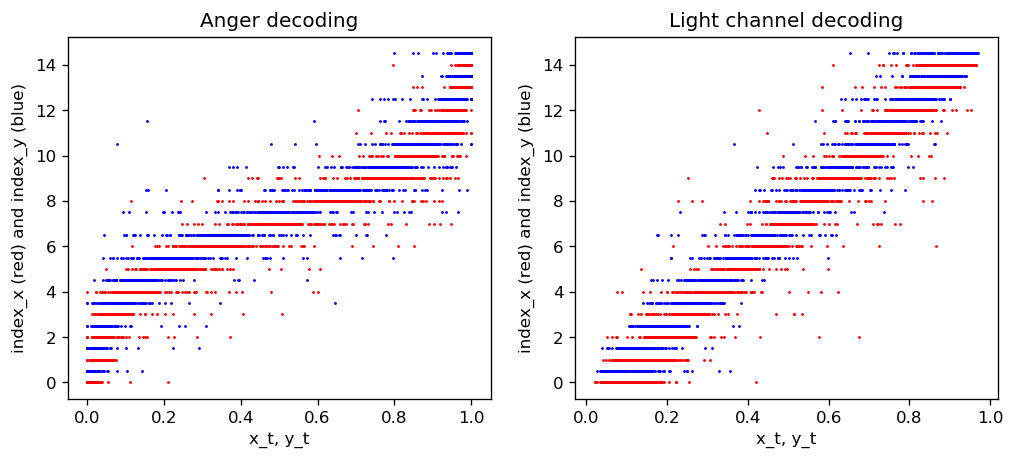

In [323]:
# E_left, E_right, E_front， E_back

# Anger decoding
# x_t, y_t

# light channel docoding
# x_b, y_b
N=3000

fig, ax = plt.subplots(1,2,figsize=(10,4))
ax[0].title.set_text('Anger decoding')
ax[0].scatter(x_t[:N], df0['index_x'][0:N], color = 'red', s=0.5)
ax[0].scatter(y_t[:N], df0['index_y'][0:N]+0.5, color = 'blue', s=0.5)
ax[0].set(xlabel='x_t, y_t', ylabel='index_x (red) and index_y (blue)')

ax[1].title.set_text('Light channel decoding')
ax[1].scatter(x_b[:N], df0['index_x'][0:N], color = 'red', s=0.5)
ax[1].scatter(y_b[:N], df0['index_y'][0:N]+0.5, color = 'blue', s=0.5)
ax[1].set(xlabel='x_t, y_t', ylabel='index_x (red) and index_y (blue)')


In [266]:
#==============================================================================
# split the dataset into training and test set use 80/20 approach
#==============================================================================

from sklearn.model_selection import train_test_split
X_train, X_test, pixel_xy_train, pixel_xy_test = train_test_split (X, pixel_xy, test_size = 0.2, random_state = 0)


#### 5.2 Tainning with ML algorithms

# To be continued ...